In [1]:
import numpy as np
import networkx as nx
import random

In [2]:
def get_network_opinion(network):
    opinion = np.array([])
    for i in range( network.G.number_of_nodes()):
        a = network.output_opinion(i)
        opinion = np.append(opinion , a)
    opinion = opinion.reshape(1 , 100)
    return opinion

def network_give_opinion(network , input_opinion):
       for i in range(network.G.number_of_nodes()):
            network.input_opinion(i , input_opinion[i])
            network.update_opinions()
class Agent:
    def __init__(self, opinion):
        self.opinion = opinion

class SmallWorldNetwork:
    def __init__(self, N, E, p):
        self.G = nx.watts_strogatz_graph(N, E, p)

        # Add weights to the edges of the network
        for edge in self.G.edges():
            self.G[edge[0]][edge[1]]['weight'] = random.uniform(0, 1)

        self.agents = [Agent(random.random()) for i in range(N)]

    def input_opinion(self, node_id, opinion):
        self.agents[node_id].opinion = opinion

    def output_opinion(self, node_id):
        return self.agents[node_id].opinion

    def update_opinions(self):
        for node_id in self.G.nodes():
            neighbors = self.G.neighbors(node_id)

            # Convert the neighbors variable to a list
            neighbors_list = list(neighbors)

            # Check if the agent has at least one neighbor
            if len(neighbors_list) > 0:
                weighted_average_opinion = sum([self.agents[neighbor].opinion * self.G[node_id][neighbor]['weight'] for neighbor in neighbors_list]) / sum([self.G[node_id][neighbor]['weight'] for neighbor in neighbors_list])

                # Update the agent's opinion based on the French DeGroot model
                self.agents[node_id].opinion = weighted_average_opinion

                # Add some noise to the agent's opinion
                self.agents[node_id].opinion += random.uniform(-0.1, 0.1)



In [3]:
def normal_network_reset(network , center , diviation):
    for i in range(network.G.number_of_nodes()):
        network.input_opinion(i ,np.random.normal(loc = center , scale=diviation) ) 
    network.update_opinions()

In [4]:
network = SmallWorldNetwork(100, 50 , 0.1)

In [9]:
import keras
from keras.layers import Input , Dense , Dropout , LayerNormalization 
from keras.models import Model

input_layer = Input(shape=(network.G.number_of_nodes()))
x = Dense(128 , activation='relu' , kernel_regularizer=keras.regularizers.L2())(input_layer)
x = Dropout(0.001)(x)
x = LayerNormalization()(x)
x = Dense(110, activation='relu' , kernel_regularizer=keras.regularizers.L2())(x)
x = Dropout(0.1)(x)
x = LayerNormalization()(x)
output_layer = Dense(100 , activation='sigmoid' , kernel_regularizer=keras.regularizers.L2())(x)

single_agent = Model(inputs = input_layer , outputs = output_layer)
single_agent.compile(optimizer='adam' , loss=keras.losses.huber)
single_agent.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 128)               12928     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 layer_normalization_2 (Lay  (None, 128)               256       
 erNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 110)               14190     
                                                                 
 dropout_3 (Dropout)         (None, 110)               0         
                                                           

In [10]:
ref_opinion = 0.75
iter = 0
single_agent = Model(inputs = input_layer , outputs = output_layer)
single_agent.compile(optimizer='adam' , loss='mse')
normal_network_reset(network = network , center = 0.5 , diviation= 0.1)
opinion = get_network_opinion(network)
mean_opinion_history = [opinion.mean()]
error_history = [ref_opinion - opinion.mean()]

opinion_history = [opinion]
input_history = [np.random.normal(loc=0.5 , scale=0.1 , size=(1 , 100))]
while iter<150 or abs(error)<0.001:
   opinion = get_network_opinion(network)
   net_input = single_agent.predict(opinion , verbose=2)
   network_give_opinion(network , net_input[0])
   new_opinion = get_network_opinion(network)
   mean_opinion_history.append(new_opinion.mean())
   opinion_history.append(opinion)
   input_history.append(net_input)
   error = ref_opinion - new_opinion.mean()
   error_history.append(error)
   single_agent.fit(opinion , (1+error)*net_input , epochs=1 , batch_size=1 , verbose=2)
   iter+=1

1/1 - 0s - 63ms/epoch - 63ms/step
1/1 - 0s - loss: 3.3972 - 291ms/epoch - 291ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - loss: 3.3414 - 17ms/epoch - 17ms/step
1/1 - 0s - 11ms/epoch - 11ms/step
1/1 - 0s - loss: 3.2882 - 16ms/epoch - 16ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - loss: 3.2132 - 15ms/epoch - 15ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - loss: 3.1600 - 15ms/epoch - 15ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - loss: 3.0999 - 15ms/epoch - 15ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - loss: 3.0482 - 15ms/epoch - 15ms/step
1/1 - 0s - 11ms/epoch - 11ms/step
1/1 - 0s - loss: 2.9771 - 14ms/epoch - 14ms/step
1/1 - 0s - 11ms/epoch - 11ms/step
1/1 - 0s - loss: 2.9259 - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - loss: 2.8744 - 13ms/epoch - 13ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - loss: 2.8238 - 15ms/epoch - 15ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - loss: 2.7693 - 14ms/epoch - 14ms/step
1/

In [7]:
import matplotlib.pyplot as plt 

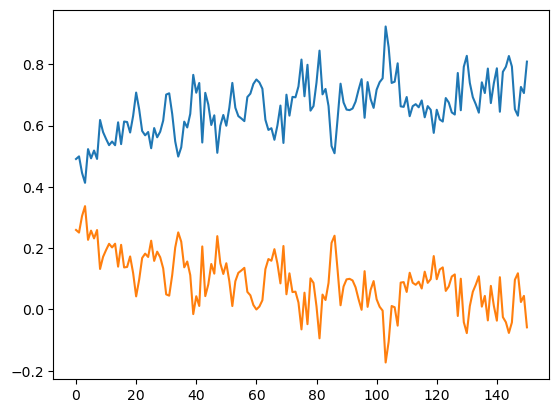

In [11]:
plt.plot(mean_opinion_history)
plt.plot(error_history)